In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


Importing Libraries

In [2]:
#Data visualization libraries
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
#Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB





Getting the data

In [3]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/train.csv")

Exploratory data analysis

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The data has 891 entries and 3 data types. 2 of the features are floats,5 are integers and 5 are objects. 

In [5]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
#Check for missing values
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

There's missing data in Age, cabin and Embarked.

What features/columns would contribute to a high survival rate? It would make sense if Sex, Age, P-class, Parch, fare, SibSp, Cabin and Embarked would be correlated with a high survival rate. 

1. Age and Sex correlation with survival rate

Text(0.5, 1.0, 'Distribution of survival rate in men')

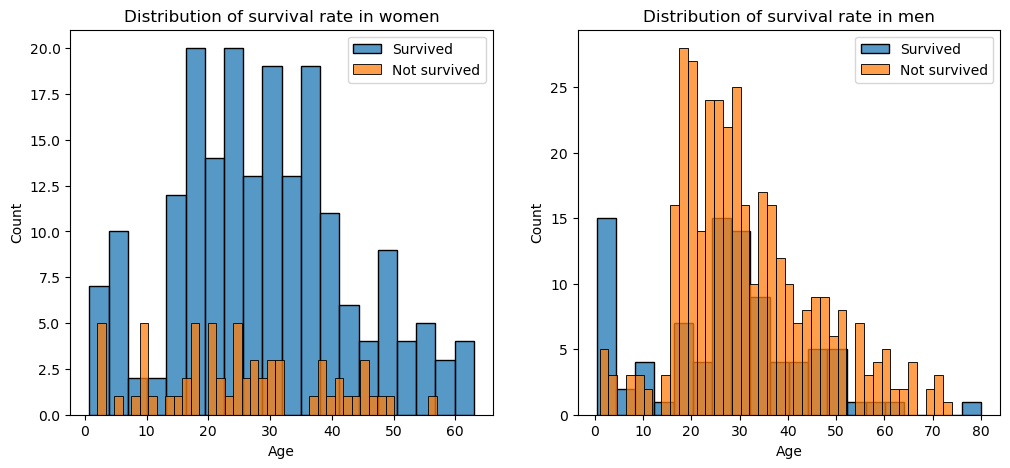

In [7]:
#Define variables
survived = 'survived'
not_survived = 'not survived'
# Split data by gender
women = train_data[train_data['Sex']== 'female']
men = train_data[train_data['Sex']=='male']
#Visualizing the data using subplots
fig, axes = plt.subplots(nrows=1,ncols=2, figsize = (12, 5))
ax = sns.histplot(women[women['Survived']== 1].Age.dropna(),bins = 20, label = 'Survived', ax = axes[0],kde= False)
ax = sns.histplot(women[women['Survived']== 0].Age.dropna(),bins = 40, label = 'Not survived',ax = axes[0], kde= False)
ax.legend()
ax.set_title('Distribution of survival rate in women')
ax = sns.histplot(men[men['Survived']== 1]. Age.dropna(), bins= 20, label = 'Survived', ax= axes[1], kde= False)
ax = sns.histplot(men[men['Survived']== 0]. Age.dropna(), bins= 40, label = 'Not survived', ax= axes[1], kde= False)
ax.legend()
ax.set_title('Distribution of survival rate in men')

From the distribution above it is clear that gender is highly correlated with survival rate. Women aged 14-40 are more likely to survive while in men, ages 18-30 have a high probability of surviving

2. Embarked,P-Class and Sex

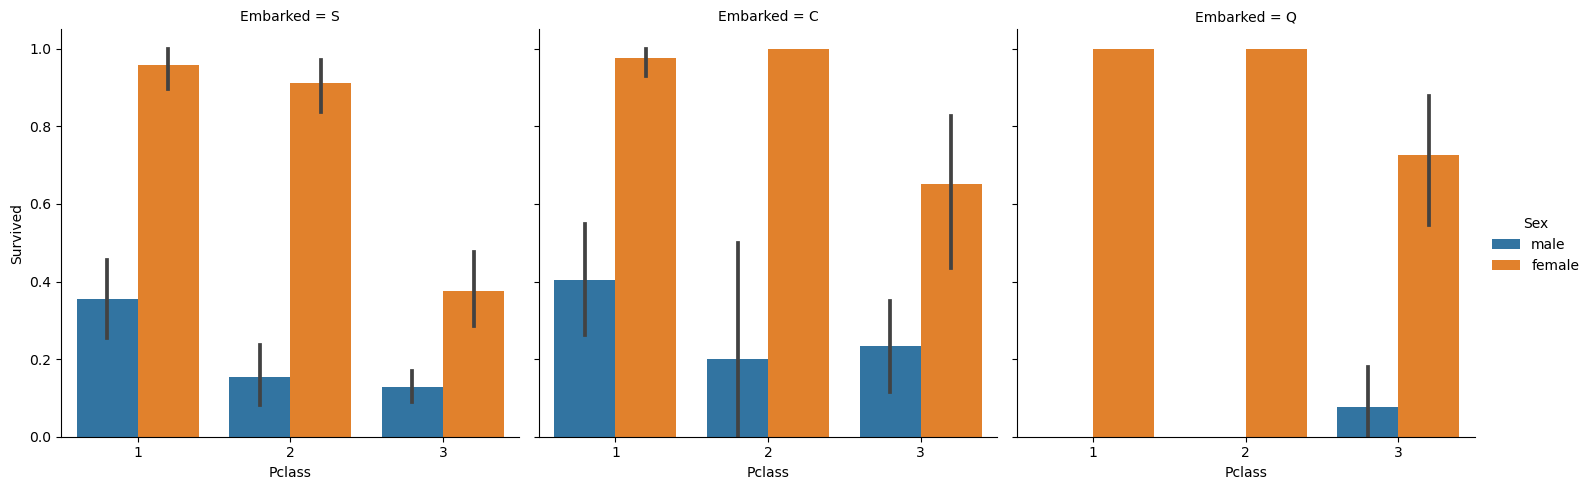

In [8]:
sns.catplot(data= train_data, x= 'Pclass', y='Survived', hue= 'Sex',col= 'Embarked',kind= 'bar')


Ports used to embark the Titanic somewhat influenced the survival rates especially gender-wise. Women had a high chance of survival if they embarked at port Q while men had a higher chance at Port C. I will show the correlation of P-class and Survival rate exclusively.`

3. P-class

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

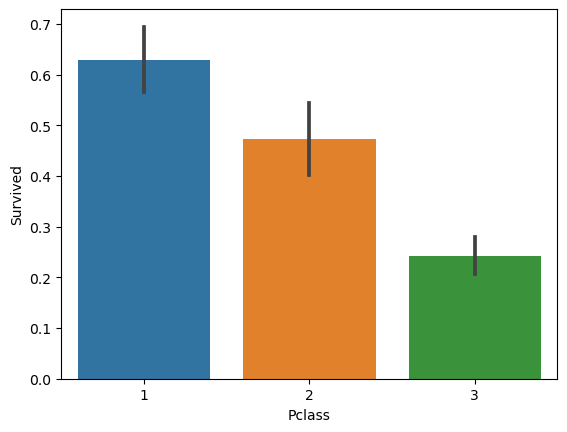

In [9]:
sns.barplot(data= train_data, x= 'Pclass',y= 'Survived')

Pclass influences survival rates. With high probability of survival in Pclass 1 and the lowest in 3

4. SibSp and Parch
It makes sense if these two variables are analysed together as it influences the number of relatives abode which can have an effect on probability of survival 

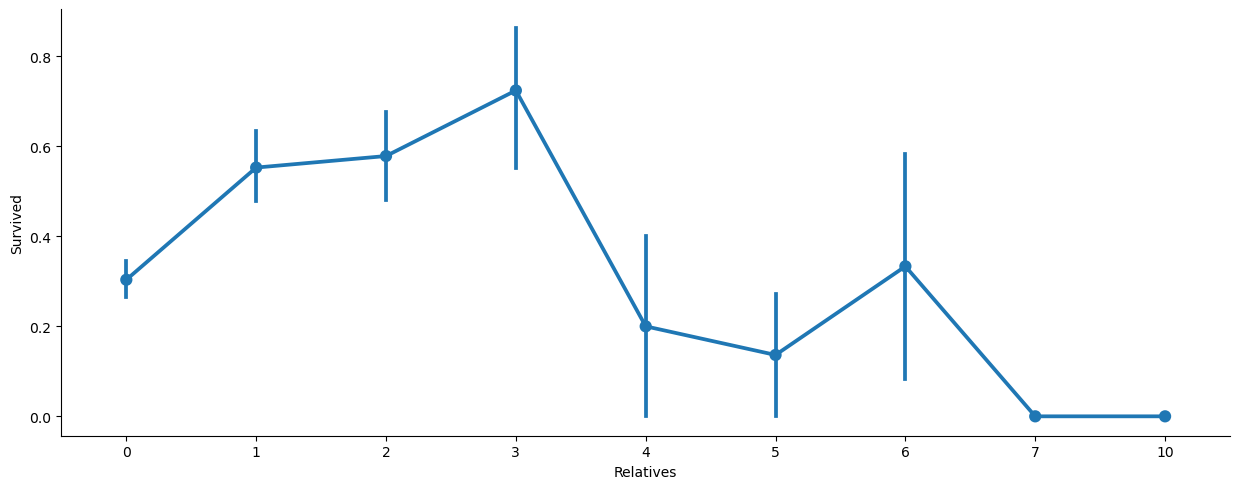

In [10]:
#Counts of People who were travelling alone vs those who had a relative onboard
train_data['Relatives'] = train_data['SibSp'] + train_data['Parch']
test_data['Relatives'] = test_data['SibSp'] + test_data['Parch']
train_data['NotAlone'] = train_data['Relatives'].apply(lambda x: 0 if x > 0 else 1).astype(int)
train_data['NotAlone'].value_counts()

#Plot 
sns.catplot(data=train_data, x='Relatives', y='Survived', kind='point', aspect=2.5)

The number of relatives influences survival rates differently. With high survival rates being observed if you had 1 to 3 relatives and lower if you had 0 or more than three relatives.

**Data Pre-processing.**

In [11]:
#Missing data
#Cabin data
import re
Deck = {"A": 1,"B" : 2, "C" : 3, "D": 4, "E" : 5,"F" : 6, "G": 7, "U": 8}
data = [train_data, test_data]
for dataset in data:
    dataset['Deck']= dataset['Cabin'].str.extract('([A-Za-z])',expand = False)
    dataset['Deck']= dataset['Deck'].map(Deck)
    dataset['Deck']= dataset['Deck'].fillna(0)
    dataset['Deck']= dataset['Deck'].astype(int)
    dataset.drop('Cabin',axis=1,inplace=True)



I created a dictionary so as to extract letters in the Cabin feature and assign them to values in the dictionary which is converted to integers. The Cabin feature is then dropped from the dataset

In [12]:
#Age
import random
for dataset in [train_data,test_data]:
    mean_age = train_data["Age"].mean()
    std_age = test_data["Age"].std()
    num_null= dataset["Age"].isnull().sum()
    #Generate random values using mean and standard deviation
    random_ages = [random.uniform(mean_age - std_age, mean_age + std_age)for i in range(num_null)]
    dataset.loc[np.isnan(dataset["Age"]), "Age"] = random_ages
    dataset["Age"]= dataset["Age"].astype(int)
train_data["Age"].isnull().sum()

0

I generate random values based on the mean of ages in the train data and standard deviation in the test_data used to fill the NaN values in the train_data Age column. 

In [13]:
#Embarked
train_data['Embarked'].describe()
#Fill missing values with the most common value
common_port = "S"
for dataset in [train_data, test_data]:
    dataset["Embarked"] = dataset["Embarked"].fillna(common_port)

**Converting Features**

1. Fare
Converting fare to integers

In [14]:
for dataset in [train_data, test_data]:
    dataset["Fare"] = dataset["Fare"].fillna(0)
    dataset["Fare"] = dataset["Fare"].astype(int)

2. Sex
Assigning dummy variables to Sex and converting to numeric

In [15]:
Gender = {"male":0, "female":1}
for dataset in [train_data, test_data]:
    dataset["Sex"] = dataset["Sex"].map(Gender)

3. Embarked
Converting embarked feature to numeric

In [16]:
ports = {"S": 0, "C": 1, "Q": 2}
for dataset in [train_data, test_data]:
    dataset["Embarked"] = dataset["Embarked"].map(ports)

4. Name
Extracting titles in Names and converting them to numeric

In [17]:
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in [train_data, test_data]:
    # extract titles using regular expression
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace uncommon titles with "Rare"
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don',
                                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles).fillna(0).astype(int)
    # drop the Name column
    dataset.drop('Name', axis=1, inplace=True)

    

In [18]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  891 non-null    int64 
 1   Survived     891 non-null    int64 
 2   Pclass       891 non-null    int64 
 3   Sex          891 non-null    int64 
 4   Age          891 non-null    int64 
 5   SibSp        891 non-null    int64 
 6   Parch        891 non-null    int64 
 7   Ticket       891 non-null    object
 8   Fare         891 non-null    int64 
 9   Embarked     891 non-null    int64 
 10  Relatives    891 non-null    int64 
 11  NotAlone     891 non-null    int64 
 12  Deck         891 non-null    int64 
 13  Title        891 non-null    int64 
dtypes: int64(13), object(1)
memory usage: 97.6+ KB


**Dropping unnecessary variables**

In [19]:
for dataset in [train_data, test_data]:
    dataset.drop('Ticket', axis=1, inplace=True)

In [20]:
train_data = train_data.drop(['PassengerId'], axis=1)

**Creating Categories**
Categorizing the fare price and age helps to reduce the impact of outliers or extreme values, which may skew the results or make it difficult to draw meaningful conclusions. I create age brackets and fare groups instead of removing outliers because in this case it would affect the prediction.

1. Age

In [21]:
for dataset in [train_data, test_data]:
    dataset['AgeGroup'] = pd.cut(dataset['Age'], [0, 12, 19, 22, 29, 36, 45, 65], labels=[0, 1, 2, 3, 4, 5, 6])
    dataset.drop('Age', axis=1,inplace= True)
train_data['AgeGroup'].value_counts()


4    188
3    186
5    143
1    120
6     93
2     84
0     62
Name: AgeGroup, dtype: int64

2. Fare

In [22]:
for dataset in [train_data, test_data]:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)


In [23]:
for dataset in [train_data, test_data]: 
    dataset['Fare'] = pd.to_numeric(dataset['Fare'], errors='coerce')
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

**Creating a New feature**
1. Fare Per Person

In [24]:
for dataset in [train_data, test_data]:
    dataset['Fare_Per_Person'] = dataset.apply(lambda row: row['Fare'] / (row['Relatives'] + 1), axis=1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)

In [25]:
train_data

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Relatives,NotAlone,Deck,Title,AgeGroup,Fare_Per_Person
0,0,3,0,1,0,0,0,1,0,0,1,2,0
1,1,1,1,1,0,3,1,1,0,3,3,5,1
2,1,3,1,0,0,0,0,0,1,0,2,3,0
3,1,1,1,1,0,3,0,1,0,3,3,4,1
4,0,3,0,0,0,1,0,0,1,0,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,0,0,1,0,0,1,0,5,3,1
887,1,1,1,0,0,2,0,0,1,2,2,1,2
888,0,3,1,1,2,2,0,3,0,0,2,5,0
889,1,1,0,0,0,2,1,0,1,3,1,3,2


**Building a Machine Learning Model **
Using Random Forest

In [26]:
X_train = train_data.drop("Survived", axis=1)
Y_train = train_data["Survived"]
X_test  = test_data.drop("PassengerId", axis=1).copy()

In [27]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

train_accuracy = random_forest.score(X_train, Y_train)
print("Training accuracy of random forest classifier:", train_accuracy)

acc_random_forest = round(train_accuracy * 100, 2)

Training accuracy of random forest classifier: 0.9281705948372615


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Survived
Feature names seen at fit time, yet now missing:
- NotAlone

  warnings.warn(message, FutureWarning)


**Feature Selection**

In [28]:
importances = pd.DataFrame()
importances['feature'] = X_train.columns
importances['importance'] = np.round(random_forest.feature_importances_, 3)
importances = importances.sort_values(by='importance', ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
Title,0.234
Sex,0.148
AgeGroup,0.146
Deck,0.090
Pclass,0.086
Fare,0.071
Relatives,0.060
Embarked,0.054
SibSp,0.040


Clearly Parch and not alone do not play a significnt role in the model. I will remove them and train the model again

**Re-running the model**

In [29]:
train_df = train_data.drop('Parch', axis=1)
test_df = test_data.drop('Parch', axis=1)



**Rerunning the model**

In [30]:
random_forest = RandomForestClassifier(n_estimators=100, oob_score = True)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

92.82 %


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Survived
Feature names seen at fit time, yet now missing:
- NotAlone

  warnings.warn(message, FutureWarning)


In [31]:
submission = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': Y_prediction})
submission.to_csv('submission.csv', sep=',', index=False)
print('Submission file created')

Submission file created


In [32]:
submission.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  891 non-null    int64
 1   Survived     891 non-null    int64
dtypes: int64(2)
memory usage: 14.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PassengerId      891 non-null    int64   
 1   Survived         891 non-null    int64   
 2   Pclass           891 non-null    int64   
 3   Sex              891 non-null    int64   
 4   SibSp            891 non-null    int64   
 5   Parch            891 non-null    int64   
 6   Fare             891 non-null    int64   
 7   Embarked         891 non-null    int64   
 8   Relatives        891 non-null    int64   
 9   Deck             891 non-null    int64   
 10  Title            891 no